In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [528]:
# # Read in data and create dataframe
# file_names = []
# path_of_the_directory= r'C:\Users\AnudeepAyinaparthi\Desktop\T20 Clustering Project\Data\t20s_male_csv2'
# print("Files and directories in a specified path:")
# for filename in os.listdir(path_of_the_directory):
#     f = os.path.join(path_of_the_directory,filename)
#     if os.path.isfile(f) and 'info' in f:
#         file_names.append(f)
# df = pd.read_csv(file_names[0])
# i = 0
# for file in file_names[1:]:
#     df1 = pd.read_csv(file)
#     df = df.append(df1)
    
# df.reset_index(drop=True,inplace=True)

# df.to_csv('T20_INFO.csv')

In [2]:
# read in data
df = pd.read_csv(r'C:\Users\AnudeepAyinaparthi\Desktop\T20 Clustering Project\Data\T20_all_matches.csv')

In [3]:
# Display data
df.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,1001349,2016/17,2017-02-17,Melbourne Cricket Ground,1,0.1,Australia,Sri Lanka,AJ Finch,M Klinger,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001349,2016/17,2017-02-17,Melbourne Cricket Ground,1,0.2,Australia,Sri Lanka,AJ Finch,M Klinger,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001349,2016/17,2017-02-17,Melbourne Cricket Ground,1,0.3,Australia,Sri Lanka,AJ Finch,M Klinger,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001349,2016/17,2017-02-17,Melbourne Cricket Ground,1,0.4,Australia,Sri Lanka,M Klinger,AJ Finch,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001349,2016/17,2017-02-17,Melbourne Cricket Ground,1,0.5,Australia,Sri Lanka,M Klinger,AJ Finch,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

### Dates

In [4]:
# Convert to datetime
df['start_date']  = pd.to_datetime(df['start_date'],infer_datetime_format=True)

In [5]:
print(f"The first match date is {df['start_date'].min()} and the last match date is {df['start_date'].max()}")

The first match date is 2005-02-17 00:00:00 and the last match date is 2022-11-16 00:00:00


In [6]:
## We will limit the data so that we only focus on T20 matches from the 2016 T20 WC onwards (After May 2016)
df = df.loc[df['start_date']>='2016-05-01']

### Completed Matches

In [7]:
num_innings = df.groupby(['match_id'])['innings'].nunique().reset_index()

In [8]:
completed_matches = list(num_innings.loc[num_innings['innings']==2]['match_id'])

In [9]:
## Limit to matches where two innings are played
num_innings = df.groupby(['match_id'])['innings'].nunique().reset_index()
completed_matches = list(num_innings.loc[num_innings['innings']==2]['match_id'])
df = df.loc[df['match_id'].isin(completed_matches)]

In [10]:
df.reset_index(drop=True,inplace=True)

### Teams

In [11]:
## Examine which teams have played matches
df['batting_team'].unique()

array(['Australia', 'Sri Lanka', 'Hong Kong', 'Ireland', 'Zimbabwe',
       'India', 'Bangladesh', 'New Zealand', 'South Africa', 'England',
       'West Indies', 'Afghanistan', 'Pakistan', 'United Arab Emirates',
       'Scotland', 'Oman', 'Netherlands', 'Papua New Guinea',
       'ICC World XI', 'Nepal', 'Philippines', 'Vanuatu',
       'United States of America', 'Germany', 'Italy', 'Ghana', 'Namibia',
       'Uganda', 'Botswana', 'Kenya', 'Nigeria', 'Guernsey', 'Denmark',
       'Norway', 'Jersey', 'Thailand', 'Malaysia', 'Maldives',
       'Singapore', 'Qatar', 'Kuwait', 'Bermuda', 'Canada',
       'Cayman Islands', 'Portugal', 'Spain', 'Gibraltar', 'Bhutan',
       'Saudi Arabia', 'Bahrain', 'Iran', 'Belgium', 'Luxembourg',
       'Czech Republic', 'Isle of Man', 'Bulgaria', 'Romania', 'Austria',
       'Greece', 'Serbia', 'Malta', 'France', 'Sweden', 'Rwanda',
       'Finland', 'Hungary', 'Estonia', 'Cyprus', 'Switzerland',
       'Swaziland', 'Lesotho', 'Seychelles', 'Malawi', 

<AxesSubplot:xlabel='batting_team'>

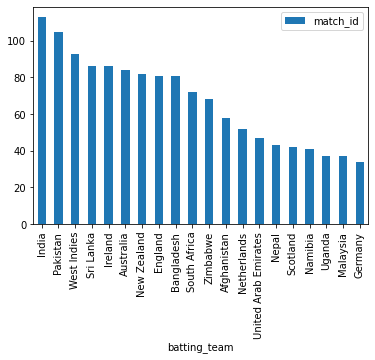

In [12]:
# How many games have the top 20 teams (by match frequency) played?
pd.DataFrame(df.groupby(['batting_team'])['match_id'].nunique()).sort_values(ascending=False,by='match_id')[0:20].plot(kind='bar')

In [13]:
## We will focus on the top 12 teams according to the latest ICC T20I rankings
top_teams = pd.read_html('https://www.espncricinfo.com/rankings/content/page/211271.html')[2]['Team'].head(12)
top_team_matches = list(df.loc[df['batting_team'].isin(top_teams)]['match_id'])
df = df.loc[df['match_id'].isin(top_team_matches)]

### High Level Overview

In [14]:
print(f"During the specified time period, {len(df['match_id'].unique())} matches have been played")

During the specified time period, 555 matches have been played


<AxesSubplot:xlabel='venue'>

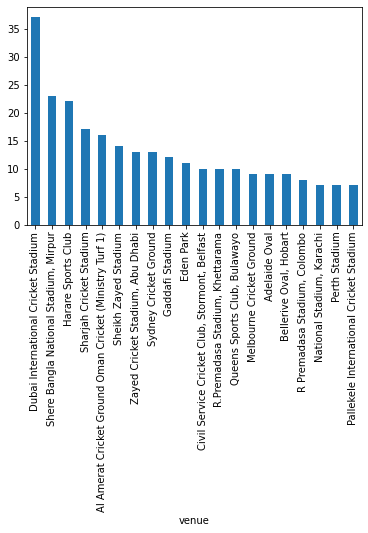

In [15]:
# Looking at which grounds have hosted the most matches
df.groupby(['venue'])['match_id'].nunique().sort_values(ascending=False)[0:20].plot(kind='bar')

## Create Match Level Data

In [17]:
# Create total runs columns by summing the 'runs_of_bat' and 'extras' columns
df['total_runs'] = df['runs_off_bat'] + df['extras']

In [18]:
# Create wicket column indicating if a wicket occured on that delivery
# Where wicket_type is null, set wicket column to 0
df.loc[df['wicket_type'].isnull(),'wicket'] = 0
# Imputate remaining fields with 1 to indicate that a wicket did occur
df['wicket'].fillna(1,inplace=True)

In [46]:
# Create match level data by aggregating on match_id and batting team
df_match_level = df.groupby(['match_id','batting_team']).agg({"ball":"max", "total_runs":"sum",'wicket':"sum",'innings':"max",'start_date':'min'})

In [47]:
# Create match level data for powerplay by limiting data to deliveris in the powerplay and then aggregate to get powerplay
# level data
df_powerplay = df.loc[df['ball']<7]
df_powerplay_agg = df_powerplay.groupby(['match_id','batting_team']).agg({"ball":"max", "total_runs":"sum",'wicket':"sum"})

In [48]:
# Join together match level and powerplay level data
df_match_level = df_match_level.join(df_powerplay_agg, rsuffix='_powerplay').drop('ball_powerplay',axis=1)

In [49]:
# Split the match level data into innings 1 and innings 2
df_match_level_inn1 = df_match_level.loc[df_match_level['innings']==1].reset_index()
df_match_level_inn2 = df_match_level.loc[df_match_level['innings']==2].reset_index()

In [50]:
df_match_level_inn1.head()

,match_id,batting_team,ball,total_runs,wicket,innings,start_date,total_runs_powerplay,wicket_powerplay
0,913633,Sri Lanka,19.6,140,10.0,1,2016-07-05,59,2.0
1,913663,England,19.6,135,7.0,1,2016-09-07,57,1.0
2,936153,South Africa,9.6,126,5.0,1,2017-01-20,74,3.0
3,936155,South Africa,19.3,113,10.0,1,2017-01-22,46,3.0
4,936157,South Africa,19.6,169,5.0,1,2017-01-25,55,1.0


In [51]:
df_match_level_inn2.head()

,match_id,batting_team,ball,total_runs,wicket,innings,start_date,total_runs_powerplay,wicket_powerplay
0,913633,England,17.3,144,2.0,2,2016-07-05,47,2.0
1,913663,Pakistan,14.5,139,1.0,2,2016-09-07,77,0.0
2,936153,Sri Lanka,9.6,107,6.0,2,2017-01-20,87,3.0
3,936155,Sri Lanka,19.4,119,7.0,2,2017-01-22,44,3.0
4,936157,Sri Lanka,19.5,170,5.0,2,2017-01-25,55,2.0


In [54]:
# Join together df_match_level_inn1 and df_match_level_inn2 tables to create a table that contains all information 
# for a match on one row
df_final = df_match_level_inn1.join(df_match_level_inn2, rsuffix='_inn2').drop(['match_id_inn2','innings','innings_inn2','start_date_inn2'],axis=1)

In [55]:
df_final.head(1)

,match_id,batting_team,ball,total_runs,wicket,start_date,total_runs_powerplay,wicket_powerplay,batting_team_inn2,ball_inn2,total_runs_inn2,wicket_inn2,total_runs_powerplay_inn2,wicket_powerplay_inn2
0,913633,Sri Lanka,19.6,140,10.0,2016-07-05,59,2.0,England,17.3,144,2.0,47,2.0


In [56]:
# Save table
df_final.to_csv(r'C:\Users\AnudeepAyinaparthi\Desktop\T20 Clustering Project\Data\df_final_cluster_match.csv',index=False,header=True)